# Meteorology Calibration and UQ

First-pass OLS estimates calibration coefficients, applies corrections, then builds UQ layers from calibrated residuals.

## 1. Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from JET3 import load_ECOv002_calval_JET_outputs

plt.style.use("default")
sns.set_palette("husl")

## 2. Load and Prepare Data

In [3]:
df = load_ECOv002_calval_JET_outputs()

# In-situ reference columns
df["insitu_RH"] = df["RH_percentage"]
df["insitu_SM"] = df["SM_surf"]

# Initial error metrics (uncalibrated)
df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
df["Ta_C_error_abs"] = df["Ta_C_error"].abs()

df["RH_error"] = df["RH"] - df["insitu_RH"]
df["RH_error_abs"] = df["RH_error"].abs()

df["SM_error"] = df["SM"] - df["insitu_SM"]
df["SM_error_abs"] = df["SM_error"].abs()

print(f"Dataset shape: {df.shape}")
print(f"Available columns: {len(df.columns)}")
df.head()

Dataset shape: (1065, 188)
Available columns: 188


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["insitu_SM"] = df["SM_surf"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP,insitu_SM,Ta_C_error,Ta_C_error_abs,RH_error,RH_error_abs,SM_error,SM_error_abs
0,0,US-NC3,ENF,Cfa,270.34520,78.53355,392.85184,307.02197,487.383423,118.91628,...,0.000109,1.943556,NaN,0.201566,0.857850,0.857850,-0.076633,0.076633,-0.009207,0.009207
1,1,US-Mi3,CVM,Dfb,232.14160,229.20093,640.11847,375.08930,106.825577,167.91946,...,0.000111,2.421845,NaN,0.420438,-2.004618,2.004618,NaN,NaN,-0.127222,0.127222
2,2,US-Mi3,CVM,Dfb,356.35574,335.23154,625.66170,284.68625,NaN,132.93634,...,0.000044,5.670131,NaN,0.406938,-4.084138,4.084138,NaN,NaN,0.026498,0.026498
3,3,US-Mi3,CVM,Dfb,332.93840,326.68680,624.25433,251.41449,178.827545,141.13242,...,0.000049,6.158837,NaN,0.398036,-1.106204,1.106204,NaN,NaN,-0.006793,0.006793
4,4,US-Mi3,CVM,Dfb,286.85403,237.21654,511.08218,228.52017,154.791626,114.80941,...,0.000058,4.846558,NaN,0.397494,-1.053609,1.053609,NaN,NaN,-0.063624,0.063624


## 3. Define Independent Variables

In [4]:
INPUT_VARIABLES = [
    "NDVI",
    "ST_C",
    "SZA_deg",
    "albedo",
    "canopy_height_meters",
    "elevation_m",
    "emissivity",
    "wind_speed_mps",
]

vars_in_df = [v for v in INPUT_VARIABLES if v in df.columns]
missing_vars = [v for v in INPUT_VARIABLES if v not in df.columns]

print(f"Independent Variables Available: {len(vars_in_df)}")
print(f"  {', '.join(vars_in_df)}")
if missing_vars:
    print(f"Missing Variables: {', '.join(missing_vars)}")

Independent Variables Available: 8
  NDVI, ST_C, SZA_deg, albedo, canopy_height_meters, elevation_m, emissivity, wind_speed_mps


## 4. Exploratory Data Analysis

ERROR METRICS SUMMARY STATISTICS
       Ta_C_error  RH_error  SM_error
count   1048.0000 1027.0000  833.0000
mean       0.9463    0.1138    0.0301
std        2.5847    0.1186    0.0937
min       -8.1564   -0.3955   -0.5442
25%       -0.6063    0.0384   -0.0094
50%        0.7325    0.1349    0.0338
75%        2.2244    0.2068    0.0727
max       14.9174    0.4845    0.6013



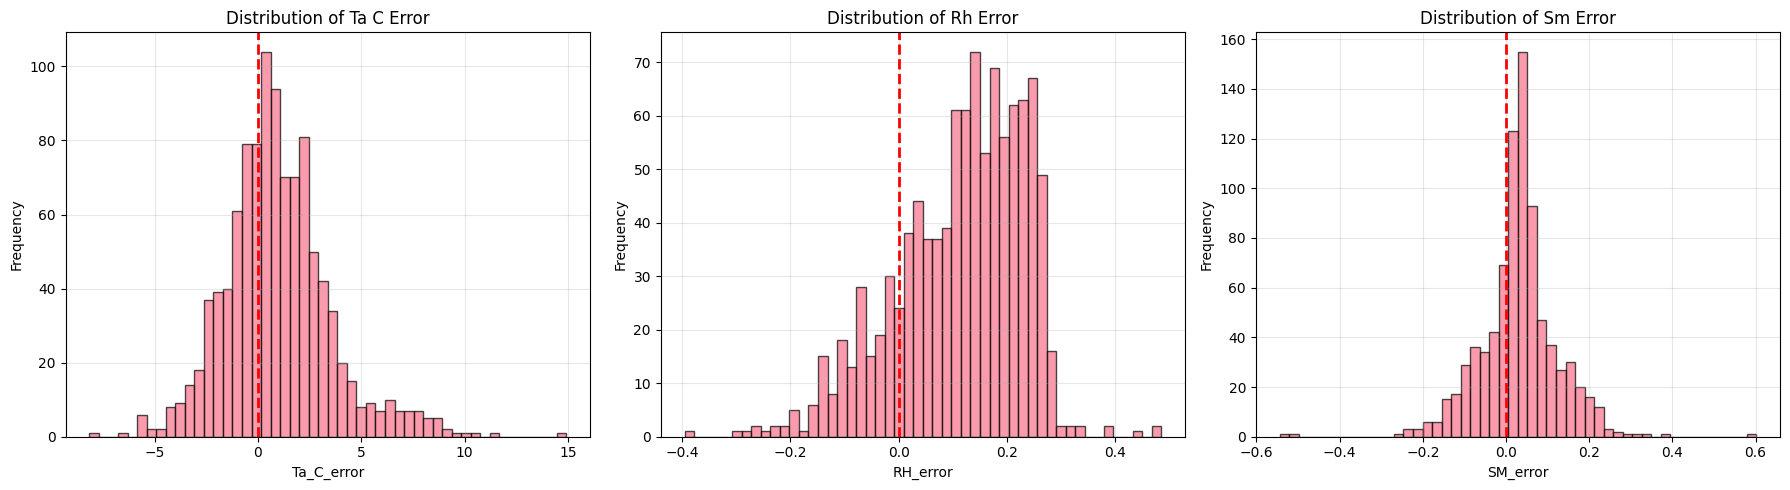

In [5]:
error_metrics = ["Ta_C_error", "RH_error", "SM_error"]
error_summary = df[error_metrics].describe()

print("=" * 80)
print("ERROR METRICS SUMMARY STATISTICS")
print("=" * 80)
print(error_summary.to_string(float_format=lambda x: f"{x:.4f}"))
print()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, error_metrics):
    data = df[metric].dropna()
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(0, color="red", linestyle="--", linewidth=2)
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {metric.replace('_', ' ').title()}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. First-Pass OLS Regression (Calibration)

In [6]:
def perform_ols_regression(df, target_col, input_vars):
    predictor_vars = [v for v in input_vars if v in df.columns]
    X = df[predictor_vars].dropna()
    y = df.loc[X.index, target_col].dropna()

    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx]
    y = y.loc[common_idx]

    ols_model = LinearRegression()
    ols_model.fit(X, y)

    X_sm = sm.add_constant(X, has_constant="add")
    ols_inference = sm.OLS(y, X_sm).fit()

    coef_df = pd.DataFrame({
        "Variable": predictor_vars,
        "Coefficient": ols_model.coef_,
        "p_value": ols_inference.pvalues.reindex(predictor_vars).values,
    }).sort_values("Coefficient", key=lambda x: x.abs(), ascending=False)

    y_pred = ols_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    vif_vals = []
    for i, col in enumerate(X.columns):
        vif_vals.append((col, variance_inflation_factor(X.values, i)))
    vif_df = pd.DataFrame(vif_vals, columns=["Variable", "VIF"]).sort_values("VIF", ascending=False)

    return {
        "model": ols_model,
        "inference": ols_inference,
        "coefficients": coef_df,
        "vif": vif_df,
        "X": X,
        "y": y,
        "y_pred": y_pred,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "predictor_vars": predictor_vars,
    }


ta_cal = perform_ols_regression(df, "Ta_C_error", INPUT_VARIABLES)
rh_cal = perform_ols_regression(df, "RH_error", INPUT_VARIABLES)
sm_cal = perform_ols_regression(df, "SM_error", INPUT_VARIABLES)

for label, results in [("Ta_C", ta_cal), ("RH", rh_cal), ("SM", sm_cal)]:
    print("=" * 80)
    print(f"CALIBRATION MODEL: {label}")
    print("=" * 80)
    print(f"R² = {results['r2']:.4f}  RMSE = {results['rmse']:.4f}  MAE = {results['mae']:.4f}")
    print(results["coefficients"].to_string(index=False, float_format=lambda v: f"{v:.6f}"))
    print()

CALIBRATION MODEL: Ta_C
R² = 0.2973  RMSE = 2.1664  MAE = 1.6223
            Variable  Coefficient  p_value
          emissivity    -5.516014 0.295179
                NDVI     1.901556 0.000012
              albedo     1.461571 0.248946
      wind_speed_mps    -0.074569 0.139483
             SZA_deg    -0.043550 0.000000
canopy_height_meters    -0.033969 0.001008
         elevation_m     0.002203 0.000000
                ST_C     0.000150 0.984830

CALIBRATION MODEL: RH
R² = 0.2938  RMSE = 0.0996  MAE = 0.0743
            Variable  Coefficient  p_value
          emissivity     0.627991 0.013898
                NDVI    -0.180705 0.000000
              albedo    -0.045821 0.433552
      wind_speed_mps     0.009642 0.000048
                ST_C     0.003984 0.000000
canopy_height_meters     0.002941 0.000000
             SZA_deg     0.001061 0.000243
         elevation_m     0.000004 0.543059

CALIBRATION MODEL: SM
R² = 0.0577  RMSE = 0.0910  MAE = 0.0622
            Variable  Coefficient

## 6. Apply Calibration Coefficients

In [7]:
def calibrate_variable(df, var_col, insitu_col, results, out_col):
    X_full = df[results["predictor_vars"]].copy()
    X_clean = X_full.dropna()
    pred_error = pd.Series(results["model"].predict(X_clean), index=X_clean.index)

    df[f"{var_col}_pred_error"] = np.nan
    df.loc[pred_error.index, f"{var_col}_pred_error"] = pred_error

    df[out_col] = df[var_col] - df[f"{var_col}_pred_error"]
    df[f"{out_col}_error"] = df[out_col] - df[insitu_col]
    df[f"{out_col}_error_abs"] = df[f"{out_col}_error"].abs()


calibrate_variable(df, "Ta_C", "insitu_Ta_C", ta_cal, "Ta_C_cal")
calibrate_variable(df, "RH", "insitu_RH", rh_cal, "RH_cal")
calibrate_variable(df, "SM", "insitu_SM", sm_cal, "SM_cal")

print("Calibrated columns: Ta_C_cal, RH_cal, SM_cal")

Calibrated columns: Ta_C_cal, RH_cal, SM_cal


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var_col}_pred_error"] = np.nan
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[out_col] = df[var_col] - df[f"{var_col}_pred_error"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

## 7. Validate Calibrated Data

In [8]:
def metrics_table(df, obs_col, est_col, label):
    aligned = pd.concat([df[obs_col], df[est_col]], axis=1).dropna()
    aligned.columns = ["obs", "est"]
    return {
        "Target": label,
        "R2": r2_score(aligned["obs"], aligned["est"]),
        "RMSE": np.sqrt(mean_squared_error(aligned["obs"], aligned["est"])),
        "MAE": mean_absolute_error(aligned["obs"], aligned["est"]),
        "N": len(aligned),
    }

rows = []
rows.append(metrics_table(df, "insitu_Ta_C", "Ta_C", "Ta_C (raw)"))
rows.append(metrics_table(df, "insitu_Ta_C", "Ta_C_cal", "Ta_C (calibrated)"))
rows.append(metrics_table(df, "insitu_RH", "RH", "RH (raw)"))
rows.append(metrics_table(df, "insitu_RH", "RH_cal", "RH (calibrated)"))
rows.append(metrics_table(df, "insitu_SM", "SM", "SM (raw)"))
rows.append(metrics_table(df, "insitu_SM", "SM_cal", "SM (calibrated)"))

metrics_df = pd.DataFrame(rows)
print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

           Target     R2   RMSE    MAE    N
       Ta_C (raw) 0.8876 2.7514 2.0251 1048
Ta_C (calibrated) 0.9304 2.1664 1.6223 1046
         RH (raw) 0.2804 0.1643 0.1425 1027
  RH (calibrated) 0.7355 0.0996 0.0743 1025
         SM (raw) 0.3531 0.0983 0.0727  833
  SM (calibrated) 0.4477 0.0910 0.0622  831


## 8. Correlation Analysis on Calibrated Data

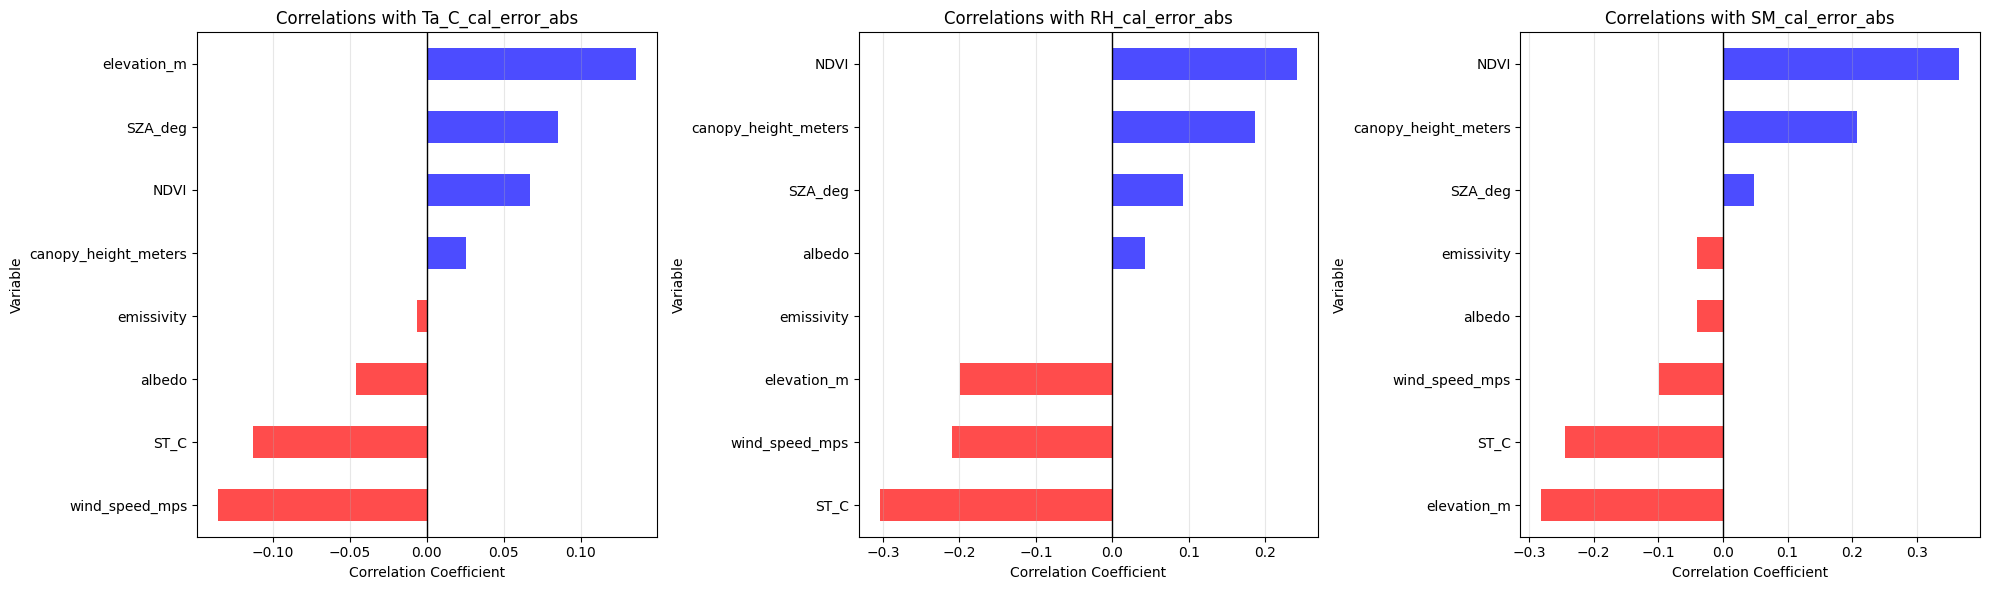

In [9]:
def calculate_correlations(df, target_col, input_vars):
    vars_in_df = [v for v in input_vars if v in df.columns]
    numeric_vars = df[vars_in_df].select_dtypes(include=[np.number]).columns.tolist()

    rows = []
    for var in numeric_vars:
        pair = df[[var, target_col]].dropna()
        if len(pair) < 3:
            continue
        r, p = pearsonr(pair[var], pair[target_col])
        if not (np.isfinite(r) and np.isfinite(p)):
            continue
        rows.append({
            "variable": var,
            "correlation": r,
            "r_square": r ** 2,
            "p_value": p,
            "n": len(pair),
        })

    return (
        pd.DataFrame(rows)
        .sort_values(by="correlation", key=lambda s: s.abs(), ascending=False)
        .set_index("variable")
    )

cal_target_cols = ["Ta_C_cal_error_abs", "RH_cal_error_abs", "SM_cal_error_abs"]
cal_corr = {t: calculate_correlations(df, t, INPUT_VARIABLES) for t in cal_target_cols}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, target in zip(axes, cal_target_cols):
    correlations = cal_corr[target]["correlation"].sort_values()
    colors = ["red" if c < 0 else "blue" for c in correlations]
    correlations.plot(kind="barh", ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel("Correlation Coefficient")
    ax.set_ylabel("Variable")
    ax.set_title(f"Correlations with {target}")
    ax.grid(True, axis="x", alpha=0.3)
    ax.axvline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

## 9. Second-Pass OLS Regression (Residual UQ)

In [10]:
ta_uq_model = perform_ols_regression(df, "Ta_C_cal_error", INPUT_VARIABLES)
rh_uq_model = perform_ols_regression(df, "RH_cal_error", INPUT_VARIABLES)
sm_uq_model = perform_ols_regression(df, "SM_cal_error", INPUT_VARIABLES)

for label, results in [("Ta_C", ta_uq_model), ("RH", rh_uq_model), ("SM", sm_uq_model)]:
    print("=" * 80)
    print(f"RESIDUAL UQ MODEL: {label}")
    print("=" * 80)
    print(f"R² = {results['r2']:.4f}  RMSE = {results['rmse']:.4f}  MAE = {results['mae']:.4f}")
    print()

RESIDUAL UQ MODEL: Ta_C
R² = 0.0000  RMSE = 2.1664  MAE = 1.6223

RESIDUAL UQ MODEL: RH
R² = 0.0000  RMSE = 0.0996  MAE = 0.0743

RESIDUAL UQ MODEL: SM
R² = -0.0000  RMSE = 0.0910  MAE = 0.0622



## 10. Generate UQ Layers for Calibrated Data

In [11]:
def build_uq_layers(results, data, alpha=0.05, bin_count=10):
    predictor_vars = results["predictor_vars"]
    X = data[predictor_vars].copy().dropna()
    if X.empty:
        return pd.DataFrame(index=data.index)

    X_sm = sm.add_constant(X, has_constant="add")
    pred = results["inference"].get_prediction(X_sm)
    pred_summary = pred.summary_frame(alpha=alpha)

    layers = pd.DataFrame(index=X.index)
    layers["error_mean"] = pred_summary["mean"]
    layers["error_se"] = pred_summary["mean_se"]
    layers["error_pi_lower"] = pred_summary["obs_ci_lower"]
    layers["error_pi_upper"] = pred_summary["obs_ci_upper"]

    train_pred = pd.Series(results["y_pred"], index=results["y"].index)
    train_resid = results["y"] - results["y_pred"]

    try:
        bin_edges = pd.qcut(train_pred, q=bin_count, retbins=True, duplicates="drop")[1]
    except ValueError:
        quantiles = np.linspace(0, 1, min(bin_count, len(train_pred)))
        bin_edges = np.unique(np.quantile(train_pred, quantiles))

    if len(bin_edges) < 3:
        global_sigma = np.nanstd(train_resid)
        layers["error_sigma_empirical"] = global_sigma
    else:
        train_bins = pd.cut(train_pred, bins=bin_edges, include_lowest=True, duplicates="drop")
        bin_sigma = train_resid.groupby(train_bins).std()
        pred_bins = pd.cut(layers["error_mean"], bins=bin_edges, include_lowest=True, duplicates="drop")
        layers["error_sigma_empirical"] = pred_bins.map(bin_sigma).astype(float)
        layers["error_sigma_empirical"] = layers["error_sigma_empirical"].fillna(np.nanstd(train_resid))

    z = 1.0  # 1-sigma
    layers["error_pi_emp_lower"] = layers["error_mean"] - z * layers["error_sigma_empirical"]
    layers["error_pi_emp_upper"] = layers["error_mean"] + z * layers["error_sigma_empirical"]

    return layers


def prefix_columns(frame, prefix):
    return frame.add_prefix(f"{prefix}_")


ta_uq = build_uq_layers(ta_uq_model, df)
rh_uq = build_uq_layers(rh_uq_model, df)
sm_uq = build_uq_layers(sm_uq_model, df)

uq_layers_cal = pd.concat(
    [
        prefix_columns(ta_uq, "Ta_C"),
        prefix_columns(rh_uq, "RH"),
        prefix_columns(sm_uq, "SM"),
    ],
    axis=1,
    join="outer",
)

uq_table = pd.DataFrame(
    [
        {"data_layer": "Ta_C_cal", "uq_layer_1sigma": "Ta_C_error_sigma_empirical"},
        {"data_layer": "RH_cal", "uq_layer_1sigma": "RH_error_sigma_empirical"},
        {"data_layer": "SM_cal", "uq_layer_1sigma": "SM_error_sigma_empirical"},
    ]
)

print("UQ layer columns:")
print(uq_layers_cal.columns.tolist())
print("\nData layers with 1-sigma UQ columns:")
print(uq_table.to_string(index=False))

UQ layer columns:
['Ta_C_error_mean', 'Ta_C_error_se', 'Ta_C_error_pi_lower', 'Ta_C_error_pi_upper', 'Ta_C_error_sigma_empirical', 'Ta_C_error_pi_emp_lower', 'Ta_C_error_pi_emp_upper', 'RH_error_mean', 'RH_error_se', 'RH_error_pi_lower', 'RH_error_pi_upper', 'RH_error_sigma_empirical', 'RH_error_pi_emp_lower', 'RH_error_pi_emp_upper', 'SM_error_mean', 'SM_error_se', 'SM_error_pi_lower', 'SM_error_pi_upper', 'SM_error_sigma_empirical', 'SM_error_pi_emp_lower', 'SM_error_pi_emp_upper']

Data layers with 1-sigma UQ columns:
data_layer            uq_layer_1sigma
  Ta_C_cal Ta_C_error_sigma_empirical
    RH_cal   RH_error_sigma_empirical
    SM_cal   SM_error_sigma_empirical


## 11. Visualization of Calibration Impact

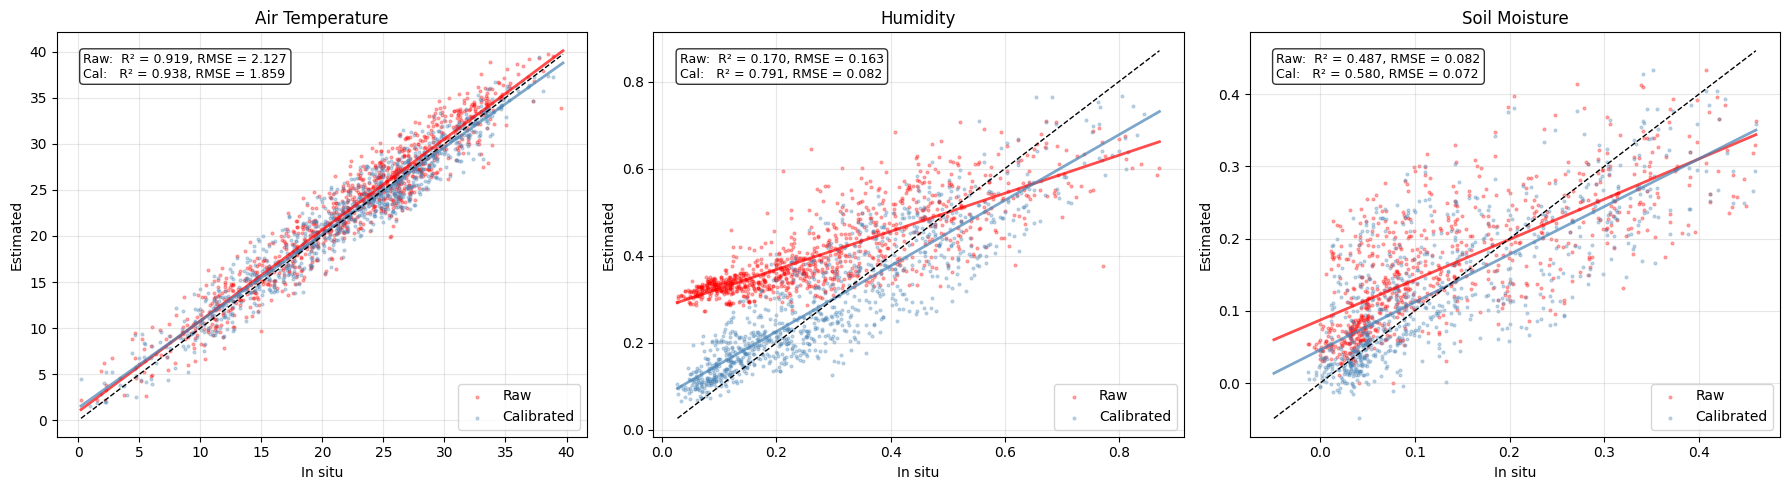

In [15]:
# Before/after: observed vs estimated
compare_specs = [
    ("insitu_Ta_C", "Ta_C", "Ta_C_cal", "Air Temperature"),
    ("insitu_RH", "RH", "RH_cal", "Humidity"),
    ("insitu_SM", "SM", "SM_cal", "Soil Moisture"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (obs_col, raw_col, cal_col, label) in zip(axes, compare_specs):
    raw = pd.concat([df[obs_col], df[raw_col]], axis=1).dropna()
    cal = pd.concat([df[obs_col], df[cal_col]], axis=1).dropna()
    
    # Remove outliers using IQR method on absolute error and observed/estimated values
    raw["abs_error"] = (raw[raw_col] - raw[obs_col]).abs()
    Q1_raw_err = raw["abs_error"].quantile(0.25)
    Q3_raw_err = raw["abs_error"].quantile(0.75)
    IQR_raw_err = Q3_raw_err - Q1_raw_err
    
    Q1_raw_obs = raw[obs_col].quantile(0.25)
    Q3_raw_obs = raw[obs_col].quantile(0.75)
    IQR_raw_obs = Q3_raw_obs - Q1_raw_obs
    
    Q1_raw_est = raw[raw_col].quantile(0.25)
    Q3_raw_est = raw[raw_col].quantile(0.75)
    IQR_raw_est = Q3_raw_est - Q1_raw_est
    
    raw = raw[
        (raw["abs_error"] >= Q1_raw_err - 1.5 * IQR_raw_err) & (raw["abs_error"] <= Q3_raw_err + 1.5 * IQR_raw_err) &
        (raw[obs_col] >= Q1_raw_obs - 1.5 * IQR_raw_obs) & (raw[obs_col] <= Q3_raw_obs + 1.5 * IQR_raw_obs) &
        (raw[raw_col] >= Q1_raw_est - 1.5 * IQR_raw_est) & (raw[raw_col] <= Q3_raw_est + 1.5 * IQR_raw_est)
    ]
    
    cal["abs_error"] = (cal[cal_col] - cal[obs_col]).abs()
    Q1_cal_err = cal["abs_error"].quantile(0.25)
    Q3_cal_err = cal["abs_error"].quantile(0.75)
    IQR_cal_err = Q3_cal_err - Q1_cal_err
    
    Q1_cal_obs = cal[obs_col].quantile(0.25)
    Q3_cal_obs = cal[obs_col].quantile(0.75)
    IQR_cal_obs = Q3_cal_obs - Q1_cal_obs
    
    Q1_cal_est = cal[cal_col].quantile(0.25)
    Q3_cal_est = cal[cal_col].quantile(0.75)
    IQR_cal_est = Q3_cal_est - Q1_cal_est
    
    cal = cal[
        (cal["abs_error"] >= Q1_cal_err - 1.5 * IQR_cal_err) & (cal["abs_error"] <= Q3_cal_err + 1.5 * IQR_cal_err) &
        (cal[obs_col] >= Q1_cal_obs - 1.5 * IQR_cal_obs) & (cal[obs_col] <= Q3_cal_obs + 1.5 * IQR_cal_obs) &
        (cal[cal_col] >= Q1_cal_est - 1.5 * IQR_cal_est) & (cal[cal_col] <= Q3_cal_est + 1.5 * IQR_cal_est)
    ]
    
    # Scatter points
    ax.scatter(raw[obs_col], raw[raw_col], s=4, alpha=0.3, label="Raw", color="red")
    ax.scatter(cal[obs_col], cal[cal_col], s=4, alpha=0.3, label="Calibrated", color="steelblue")
    
    # Calculate metrics and fit regression lines
    raw_r2 = r2_score(raw[obs_col], raw[raw_col])
    raw_rmse = np.sqrt(mean_squared_error(raw[obs_col], raw[raw_col]))
    cal_r2 = r2_score(cal[obs_col], cal[cal_col])
    cal_rmse = np.sqrt(mean_squared_error(cal[obs_col], cal[cal_col]))
    
    # Fit regression lines
    raw_coef = np.polyfit(raw[obs_col], raw[raw_col], 1)
    cal_coef = np.polyfit(cal[obs_col], cal[cal_col], 1)
    
    # Plot regression lines
    min_lim = min(raw[obs_col].min(), raw[raw_col].min(), cal[cal_col].min())
    max_lim = max(raw[obs_col].max(), raw[raw_col].max(), cal[cal_col].max())
    x_line = np.array([min_lim, max_lim])
    ax.plot(x_line, raw_coef[0] * x_line + raw_coef[1], "r-", linewidth=2, alpha=0.7)
    ax.plot(x_line, cal_coef[0] * x_line + cal_coef[1], color="steelblue", linewidth=2, alpha=0.7)
    ax.plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    
    # Add text with metrics
    textstr = f"Raw:  R² = {raw_r2:.3f}, RMSE = {raw_rmse:.3f}\nCal:   R² = {cal_r2:.3f}, RMSE = {cal_rmse:.3f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(label)
    ax.set_xlabel("In situ")
    ax.set_ylabel("Estimated")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

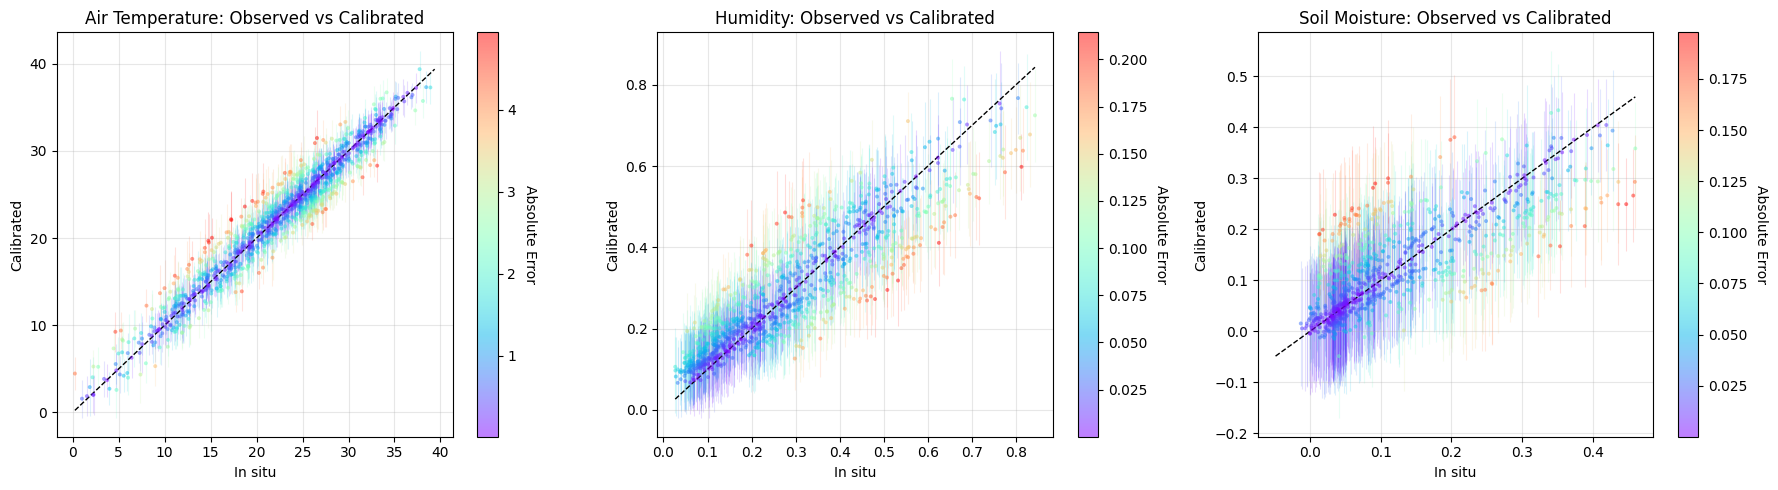

In [17]:
# Error bars on calibrated estimates with 1-sigma UQ
errorbar_specs = [
    ("insitu_Ta_C", "Ta_C_cal", "Ta_C_error_sigma_empirical", "Air Temperature"),
    ("insitu_RH", "RH_cal", "RH_error_sigma_empirical", "Humidity"),
    ("insitu_SM", "SM_cal", "SM_error_sigma_empirical", "Soil Moisture"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col_idx, (obs_col, cal_col, uq_col, label) in enumerate(errorbar_specs):
    aligned = pd.concat([df[obs_col], df[cal_col], uq_layers_cal[uq_col]], axis=1, join="inner").dropna()
    aligned.columns = ["obs", "cal", "sigma"]
    
    # Calculate absolute error for coloring
    aligned["abs_error"] = (aligned["cal"] - aligned["obs"]).abs()
    
    # Remove outliers using IQR method on absolute error, obs, and cal values
    Q1_err = aligned["abs_error"].quantile(0.25)
    Q3_err = aligned["abs_error"].quantile(0.75)
    IQR_err = Q3_err - Q1_err
    
    Q1_obs = aligned["obs"].quantile(0.25)
    Q3_obs = aligned["obs"].quantile(0.75)
    IQR_obs = Q3_obs - Q1_obs
    
    Q1_cal = aligned["cal"].quantile(0.25)
    Q3_cal = aligned["cal"].quantile(0.75)
    IQR_cal = Q3_cal - Q1_cal
    
    aligned = aligned[
        (aligned["abs_error"] >= Q1_err - 1.5 * IQR_err) & (aligned["abs_error"] <= Q3_err + 1.5 * IQR_err) &
        (aligned["obs"] >= Q1_obs - 1.5 * IQR_obs) & (aligned["obs"] <= Q3_obs + 1.5 * IQR_obs) &
        (aligned["cal"] >= Q1_cal - 1.5 * IQR_cal) & (aligned["cal"] <= Q3_cal + 1.5 * IQR_cal)
    ]

    # Plot error bars with color mapping (behind points)
    for idx in aligned.index:
        # Get color from colormap based on absolute error
        norm = plt.Normalize(vmin=aligned["abs_error"].min(), vmax=aligned["abs_error"].max())
        cmap = plt.cm.rainbow
        color = cmap(norm(aligned.loc[idx, "abs_error"]))
        
        axes[col_idx].errorbar(
            aligned.loc[idx, "obs"],
            aligned.loc[idx, "cal"],
            yerr=aligned.loc[idx, "sigma"],
            fmt="none",
            ecolor=color,
            elinewidth=0.8,
            capsize=0,
            alpha=0.15,
            zorder=1,
        )
    
    # Scatter plot colored by absolute error (on top of error bars)
    scatter = axes[col_idx].scatter(
        aligned["obs"],
        aligned["cal"],
        c=aligned["abs_error"],
        s=8,
        alpha=0.5,
        cmap="rainbow",
        edgecolors="none",
        zorder=3,
    )
    
    min_lim = min(aligned["obs"].min(), aligned["cal"].min())
    max_lim = max(aligned["obs"].max(), aligned["cal"].max())
    axes[col_idx].plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    axes[col_idx].set_title(f"{label}: Observed vs Calibrated")
    axes[col_idx].set_xlabel("In situ")
    axes[col_idx].set_ylabel("Calibrated")
    axes[col_idx].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[col_idx])
    cbar.set_label("Absolute Error", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()